/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


姓名：冉金禄
学号：23251178
当前时间: 2026-01-10 13:56:37
使用设备: cuda
正在准备数据 (CIFAR-10)...
Files already downloaded and verified
Files already downloaded and verified
训练集数量: 50000
测试集数量: 10000


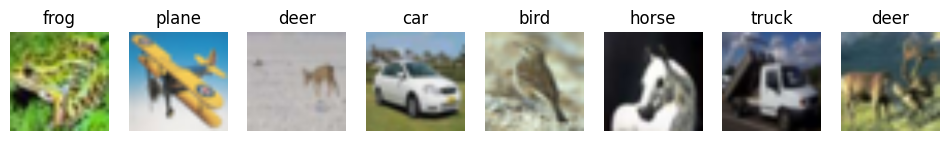

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

# ============================
# 0. 个人信息与时间信息
# ============================
print(f"姓名：冉金禄")
print(f"学号：23251178")
print(f"当前时间: {time.strftime('%Y-%m-%d %H:%M:%S')}")
# ============================
# 1. 超参数设置 (Configuration)
# ============================
BATCH_SIZE = 64        # VGG 显存占用较大，如果爆显存(OOM)，请改为 16
LEARNING_RATE = 0.01   # 初始学习率
EPOCHS = 50            # 训练轮数 (VGG收敛较慢，建议至少跑10轮，演示用可设少点)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# 设置随机种子保证可复现性
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)
print(f"使用设备: {DEVICE}")

# ============================
# 2. 数据准备 (Data Preparation)
# ============================
print("正在准备数据 (CIFAR-10)...")

# 定义预处理：VGG 标准输入是 224x224
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),       # 放大图片
    transforms.RandomHorizontalFlip(),   # 数据增强：随机翻转
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # ImageNet 标准均值方差
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 下载训练集和测试集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"训练集数量: {len(trainset)}")
print(f"测试集数量: {len(testset)}")

# ============================
# 3. 数据预览 (Data Preview)
# ============================
def imshow(img, title=None):
    # 反标准化以便显示
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# 获取一个 Batch 的图片进行展示
dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.figure(figsize=(12, 4))
# 展示前 8 张
for i in range(8):
    plt.subplot(1, 8, i+1)
    imshow(images[i], title=classes[labels[i]])
plt.show()

In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # 用于显示进度条

# ============================
# 1. 模型定义 (VGG Model)
# ============================
VGG_CONFIGS = {
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes=1000, init_weights=True, batch_norm=True):
        super(VGG, self).__init__()
        self.config = VGG_CONFIGS[vgg_name]
        self.features = self._make_layers(self.config, in_channels=3, batch_norm=batch_norm)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _make_layers(self, config, in_channels, batch_norm=False):
        layers = []
        for v in config:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# ============================
# 2. 初始化模型与优化器
# ============================
# CIFAR-10 只有 10 类，开启 batch_norm 加速收敛
model = VGG('VGG16', num_classes=10, batch_norm=True).to(DEVICE)

criterion = nn.CrossEntropyLoss()
# 使用 SGD + Momentum 是 VGG 的标准配置
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
# 学习率调度器：每 5 轮衰减一次
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ============================
# 3. 训练与验证函数
# ============================
# 用于存储历史数据以供画图
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

def train_one_epoch(epoch_index):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 使用 tqdm 显示进度条
    loop = tqdm(trainloader, desc=f"Epoch {epoch_index}/{EPOCHS} [Train]", leave=False)
    
    for inputs, targets in loop:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # 更新进度条显示的 Loss
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate(epoch_index):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        loop = tqdm(testloader, desc=f"Epoch {epoch_index}/{EPOCHS} [Eval ]", leave=False)
        for inputs, targets in loop:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(testloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# ============================
# 4. 开始训练
# ============================
print(f"开始训练 VGG-16, 总共 {EPOCHS} 轮...")

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(epoch)
    test_loss, test_acc = evaluate(epoch)
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    scheduler.step() # 更新学习率
    
    print(f"Epoch {epoch}/{EPOCHS} -> "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("训练完成！")

开始训练 VGG-16, 总共 50 轮...


Epoch 1/50 -> Train Loss: 1.6506, Train Acc: 39.97% | Test Loss: 1.3276, Test Acc: 50.90%


Epoch 2/50 -> Train Loss: 1.1645, Train Acc: 58.31% | Test Loss: 1.1738, Test Acc: 58.50%


Epoch 3/50 -> Train Loss: 0.8846, Train Acc: 69.15% | Test Loss: 0.7951, Test Acc: 72.51%


Epoch 4/50 -> Train Loss: 0.7256, Train Acc: 75.01% | Test Loss: 0.6477, Test Acc: 77.74%


Epoch 5/50 -> Train Loss: 0.6258, Train Acc: 78.36% | Test Loss: 0.6324, Test Acc: 78.20%


Epoch 6/50 -> Train Loss: 0.4717, Train Acc: 83.58% | Test Loss: 0.5044, Test Acc: 82.72%


Epoch 7/50 -> Train Loss: 0.4246, Train Acc: 85.46% | Test Loss: 0.4902, Test Acc: 83.31%


Epoch 8/50 -> Train Loss: 0.3910, Train Acc: 86.81% | Test Loss: 0.4598, Test Acc: 84.24%


Epoch 9/50 -> Train Loss: 0.3548, Train Acc: 87.88% | Test Loss: 0.4431, Test Acc: 85.30%


Epoch 10/50 -> Train Loss: 0.3283, Train Acc: 88.87% | Test Loss: 0.5411, Test Acc: 82.59%


Epoch 11/50 -> Train Loss: 0.2386, Train Acc: 91.86% | Test Loss: 0.3961, Test Acc: 87.18%


Epoch 12/50 -> Train Loss: 0.2127, Train Acc: 92.68% | Test Loss: 0.4098, Test Acc: 86.95%


Epoch 13/50 -> Train Loss: 0.1965, Train Acc: 93.15% | Test Loss: 0.4135, Test Acc: 87.48%


Epoch 14/50 -> Train Loss: 0.1846, Train Acc: 93.62% | Test Loss: 0.4042, Test Acc: 87.13%


Epoch 15/50 -> Train Loss: 0.1715, Train Acc: 94.11% | Test Loss: 0.4191, Test Acc: 87.41%


Epoch 16/50 -> Train Loss: 0.1176, Train Acc: 96.01% | Test Loss: 0.3838, Test Acc: 88.98%


Epoch 17/50 -> Train Loss: 0.0979, Train Acc: 96.69% | Test Loss: 0.4081, Test Acc: 88.91%


Epoch 18/50 -> Train Loss: 0.0890, Train Acc: 96.90% | Test Loss: 0.4063, Test Acc: 88.63%


Epoch 19/50 -> Train Loss: 0.0809, Train Acc: 97.28% | Test Loss: 0.4270, Test Acc: 89.04%


Epoch 20/50 -> Train Loss: 0.0765, Train Acc: 97.35% | Test Loss: 0.4485, Test Acc: 88.63%


Epoch 21/50 -> Train Loss: 0.0491, Train Acc: 98.42% | Test Loss: 0.4465, Test Acc: 89.58%


Epoch 27/50 -> Train Loss: 0.0204, Train Acc: 99.39% | Test Loss: 0.4748, Test Acc: 89.91%


Epoch 46/50 -> Train Loss: 0.0088, Train Acc: 99.76% | Test Loss: 0.5115, Test Acc: 90.07%


Epoch 47/50 -> Train Loss: 0.0090, Train Acc: 99.77% | Test Loss: 0.5094, Test Acc: 90.14%


Epoch 48/50 -> Train Loss: 0.0078, Train Acc: 99.81% | Test Loss: 0.5067, Test Acc: 90.28%


Epoch 49/50 -> Train Loss: 0.0083, Train Acc: 99.76% | Test Loss: 0.5080, Test Acc: 90.23%


Epoch 50/50 -> Train Loss: 0.0077, Train Acc: 99.78% | Test Loss: 0.5093, Test Acc: 90.12%
训练完成！


In [4]:
!pip install seaborn scikit-learn

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 293 kB 16.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-1.10.2/bin/python3.7 -m pip install --upgrade pip' command.


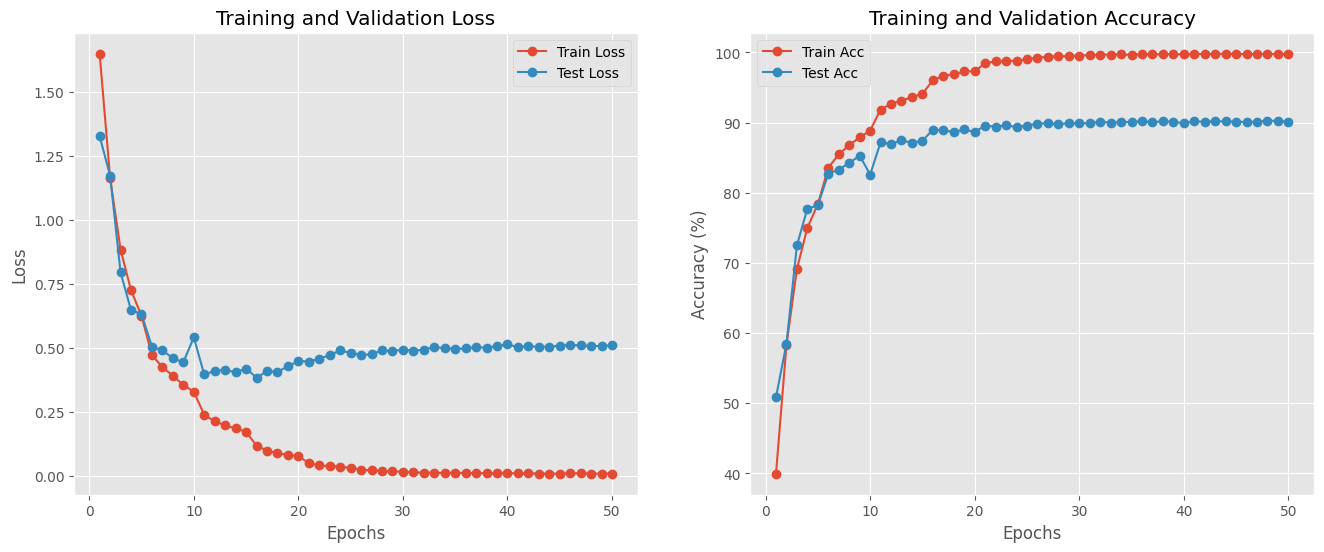

正在计算混淆矩阵...


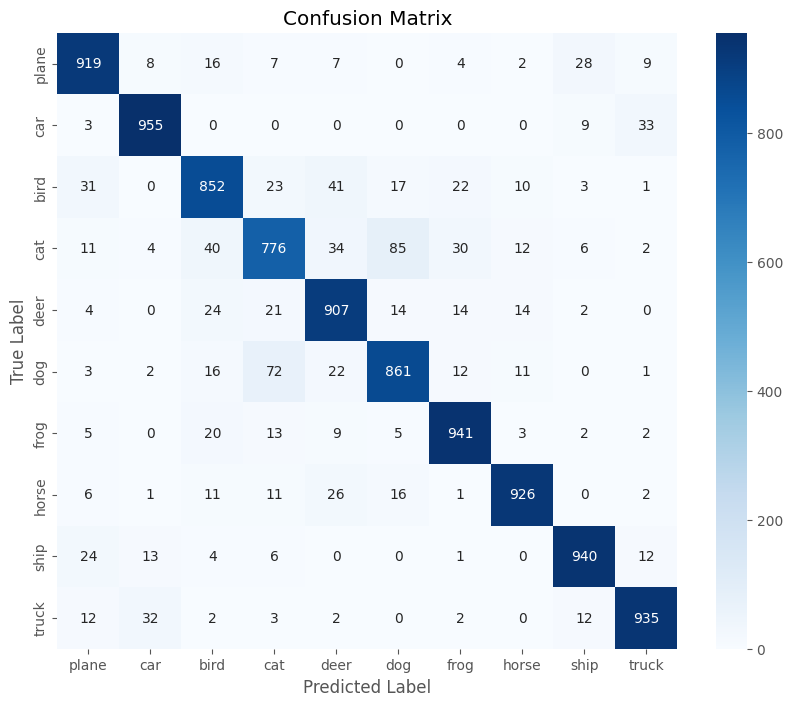

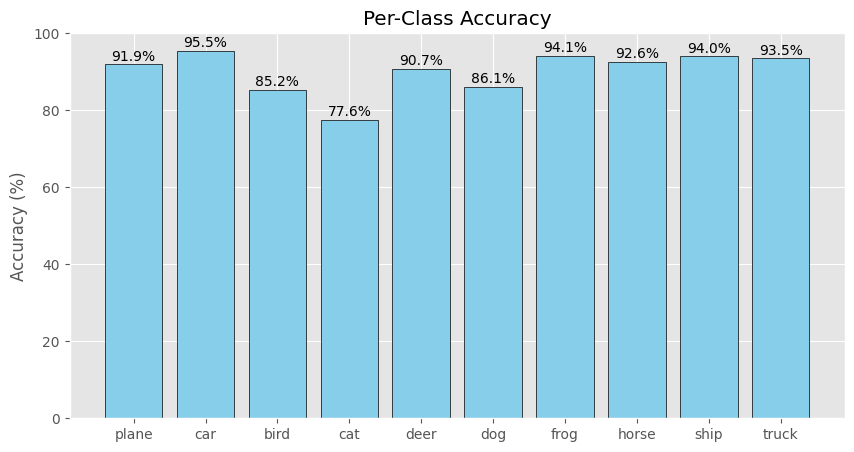

展示测试集随机样本预测结果：


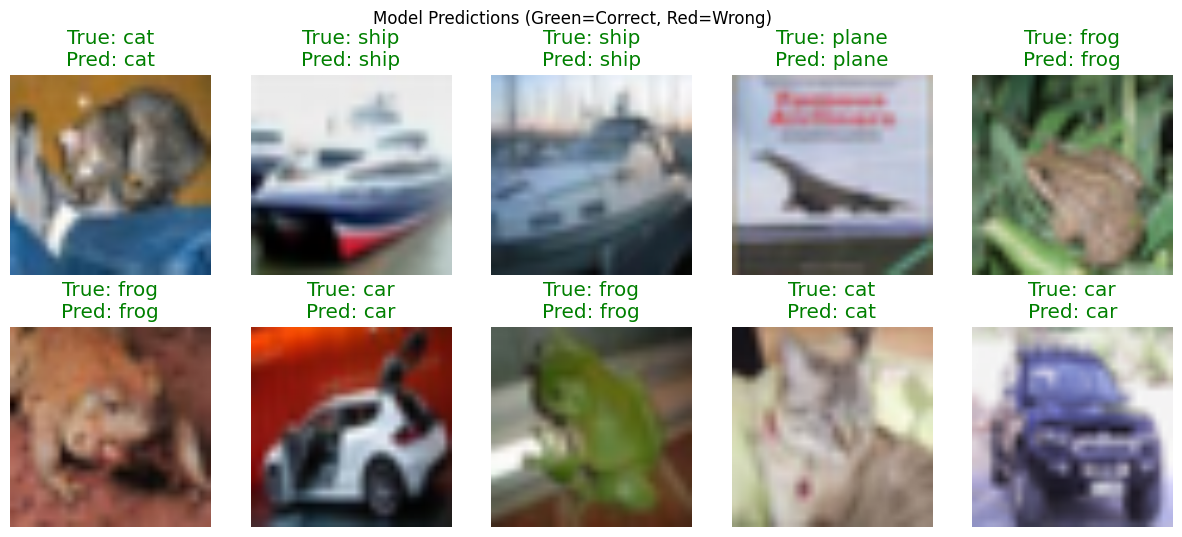

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 设置 matplotlib 风格
plt.style.use('ggplot')

# ============================
# 1. 绘制 Loss 和 Accuracy 曲线
# ============================
def plot_metrics(history):
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(16, 6))
    
    # Loss 曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs_range, history['test_loss'], label='Test Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy 曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Train Acc', marker='o')
    plt.plot(epochs_range, history['test_acc'], label='Test Acc', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_metrics(history)

# ============================
# 2. 计算混淆矩阵与每类准确率
# ============================
def get_all_preds(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.numpy())
    return np.array(all_preds), np.array(all_targets)

print("正在计算混淆矩阵...")
predictions, targets = get_all_preds(model, testloader)
cm = confusion_matrix(targets, predictions)

# 计算每个类的 Accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)

# ============================
# 3. 绘制混淆矩阵热力图
# ============================
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ============================
# 4. 绘制每类准确率柱状图
# ============================
plt.figure(figsize=(10, 5))
plt.bar(classes, class_acc * 100, color='skyblue', edgecolor='black')
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(class_acc):
    plt.text(i, v*100 + 1, f"{v*100:.1f}%", ha='center')
plt.show()

# ============================
# 5. 可视化预测样本 (True vs Pred)
# ============================
def show_predictions(loader, count=10):
    model.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    # 移回 CPU 进行画图
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()
    
    plt.figure(figsize=(15, 6))
    for i in range(count):
        ax = plt.subplot(2, 5, i+1)
        
        # 反标准化
        img = images[i] * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
              torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
        pred_label = classes[preds[i]]
        true_label = classes[labels[i]]
        
        color = 'green' if pred_label == true_label else 'red'
        
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.suptitle("Model Predictions (Green=Correct, Red=Wrong)")
    plt.show()

print("展示测试集随机样本预测结果：")
show_predictions(testloader, count=10)